# PCovC with the Iris Dataset

In [2]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV, SGDClassifier
from sklearn.inspection import DecisionBoundaryDisplay

from pcovc import PCovC

plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['scatter.edgecolors'] = "k"

random_state = 0
n_components = 2

## Load the Iris Dataset

In [3]:
iris = datasets.load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

## Scale Feature Data
#### Below, we transform the Iris feature data to have a mean of zero and standard deviation of one, while preserving relative relationships between feature values.

In [4]:
X, y = iris.data, iris.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA
#### We use Principal Component Analysis to reduce the Iris feature data to two features that retain as much information as possible about the original dataset.

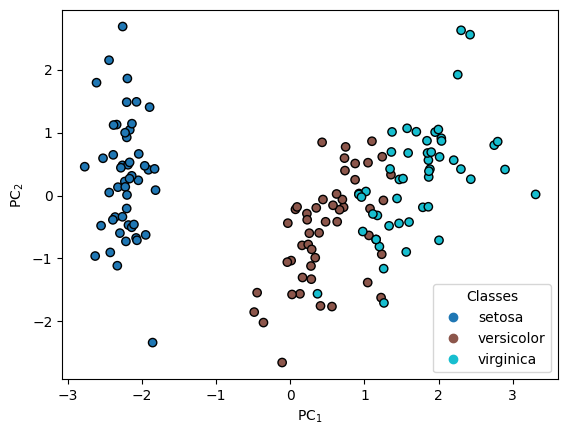

In [5]:
pca = PCA(
    n_components=n_components
)

pca.fit(X_scaled, y)
T_pca = pca.transform(X_scaled)

fig, axis = plt.subplots()
scatter = axis.scatter(T_pca[:, 0], T_pca[:, 1], c=y)
axis.set(xlabel="PC$_1$", ylabel="PC$_2$")
axis.legend(scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")

## Effect of Mixing Parameter $\alpha$ on PCovC Map
#### Below, we see how different $\alpha$ values for our PCovC model result in varying class distinctions between setosa, versicolor, and virginica on the PCovC map.

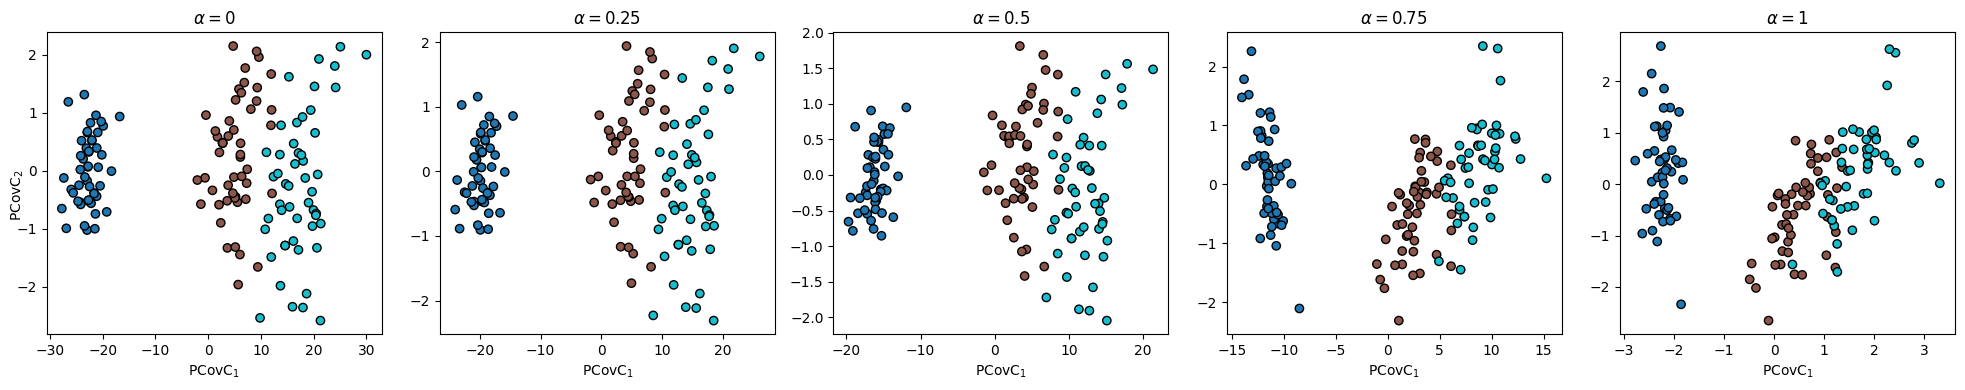

In [6]:
n_mixing = 5
mixing_params = [0, 0.25, 0.50, 0.75, 1]

fig, axes = plt.subplots(1, n_mixing, figsize=(4*n_mixing, 4))

for id, graph in enumerate(axes.flat):
    mixing = mixing_params[id]

    pcovc = PCovC(
        mixing=mixing, 
        n_components=n_components, 
        random_state=random_state, 
        classifier=LogisticRegressionCV()
    )
    
    pcovc.fit(X_scaled, y) 
    T = pcovc.transform(X_scaled)
    
    graph.set_title(r"$\alpha=$" + str(mixing))
    graph.set_xlabel("PCovC$_1$")
    graph.scatter(T[:, 0], T[:, 1], c=y)
    
fig.supylabel("PCovC$_2$", fontsize=10)

fig.tight_layout()

## Effect of PCovC Classifier on PCovC Map and Decision Boundaries
#### Here, we see how a PCovC model ($\alpha=$ 0.25) fitted with different classifiers produces varying PCovC maps. In addition, we see the varying decision boundaries produced by the respective PCovC classifiers overlayed onto the PCovC maps.

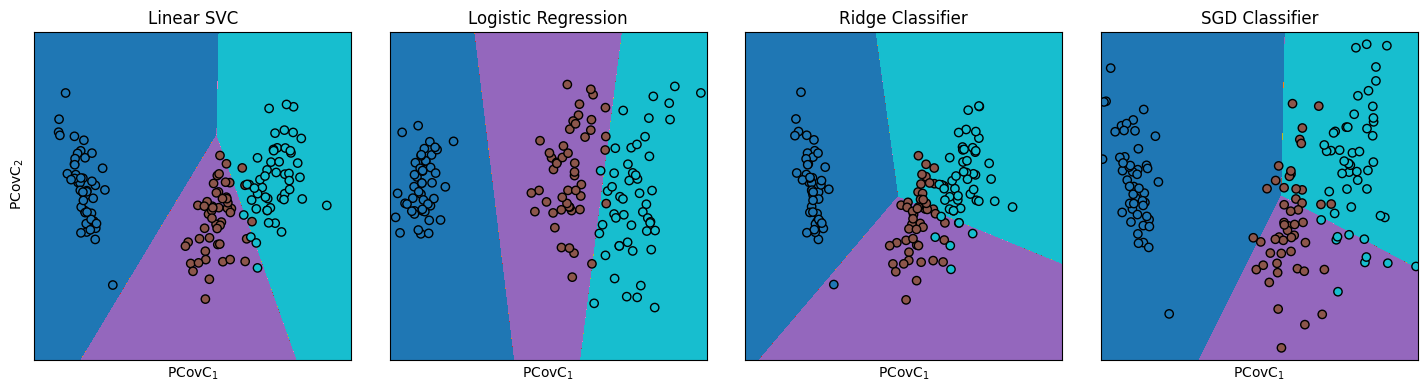

In [11]:
mixing = 0.25
n_models = 4
fig, axes = plt.subplots(1, n_models, figsize=(4*n_models, 4))

models = {
    LinearSVC(
         random_state=random_state
    ): "Linear SVC",

    LogisticRegressionCV(
         random_state=random_state
    ): "Logistic Regression",

    RidgeClassifierCV(): "Ridge Classifier",

    SGDClassifier(
         random_state=random_state
    ): "SGD Classifier"  
}

for id, graph in enumerate(axes.flat):
     model = list(models)[id]
    
     pcovc = PCovC(
        mixing=mixing, 
        n_components=n_components, 
        random_state=random_state, 
        classifier=model
     )

     pcovc.fit(X_scaled, y)
     T = pcovc.transform(X_scaled)

     graph = axes.flat[id]
     graph.set_title(models[model])

     DecisionBoundaryDisplay.from_estimator(
          estimator=pcovc.classifier_, 
          X=T, 
          ax=graph, 
          response_method="predict", 
          grid_resolution=2000,
     )

     graph.set_xlabel("PCovC$_1$")
     graph.scatter(T[:, 0], T[:, 1], c=y)

     graph.set_xticks([])
     graph.set_yticks([])

     
fig.supylabel("PCovC$_2$", fontsize=10)
fig.subplots_adjust(wspace=0.12, hspace=0.05, left=0.035, bottom=0.06)